In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, LinearRegression, ElasticNetCV
from lightgbm import LGBMRegressor
from sklearn.metrics.pairwise import cosine_similarity
from category_encoders import CatBoostEncoder, OneHotEncoder
from collections import defaultdict
from hyperopt import fmin, tpe, hp

warnings.simplefilter("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#!curl -L -o mercedes.zip https://www.dropbox.com/s/1bsch7envl9m1ba/mercedes-benz-greener-manufacturing.zip?dl=1
#!unzip *.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  577k  100  577k    0     0   373k      0  0:00:01  0:00:01 --:--:-- 5206k


In [2]:
df_val = pd.read_csv('test.csv')
df_train = pd.read_csv('train.csv')
df_submit = pd.read_csv('sample_submission.csv')

In [3]:
df_val.set_index('ID', inplace=True)
df_train.set_index('ID', inplace=True)
df_submit.set_index('ID', inplace=True)

In [4]:
# Знакомство с данными

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4209 entries, 0 to 8417
Columns: 377 entries, y to X385
dtypes: float64(1), int64(368), object(8)
memory usage: 12.1+ MB


In [6]:
df_train.head()

,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,...,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,130.81,k,v,at,a,d,u,j,o,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
6,88.53,k,t,av,e,d,y,l,o,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
7,76.26,az,w,n,c,d,x,j,x,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9,80.62,az,t,n,f,d,x,l,e,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
13,78.02,az,v,n,f,d,h,d,n,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
df_train.select_dtypes(include='object')

,X0,X1,X2,X3,X4,X5,X6,X8
ID,,,,,,,,
0,k,v,at,a,d,u,j,o
6,k,t,av,e,d,y,l,o
7,az,w,n,c,d,x,j,x
9,az,t,n,f,d,x,l,e
13,az,v,n,f,d,h,d,n
...,...,...,...,...,...,...,...,...
8405,ak,s,as,c,d,aa,d,q
8406,j,o,t,d,d,aa,h,h
8412,ak,v,r,a,d,aa,g,e


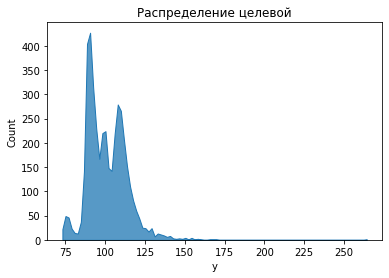

In [8]:
sns.histplot(data=df_train, x='y', bins=100, element='poly').set_title('Распределение целевой');

In [9]:
# отрисовывает идентичные признаки
def plot_identical_features(df):
  plt.figure(figsize=(30,15))
  corr = df.corr().abs()
  print(f"Идентичных бинарных признаков: {len(get_identical_features(corr))}")
  mask = np.zeros_like(corr, dtype=bool)
  mask[np.tril_indices_from(corr)] = True
  corr[mask] = 0
  corr[corr < 0.99] = 0

  sns.heatmap(corr, xticklabels=False, yticklabels=False);

# получаем список идентичных признаков
def get_identical_features(corr):
  corr = corr.abs()
  features = {}

  for i in range(0, corr.shape[1] - 1):
    names = corr.iloc[i, i+1:] > 0.99
    if names.sum() > 0:
      features[names.name] = names[names].index.values.tolist()
    
  return features  

Идентичных бинарных признаков: 60


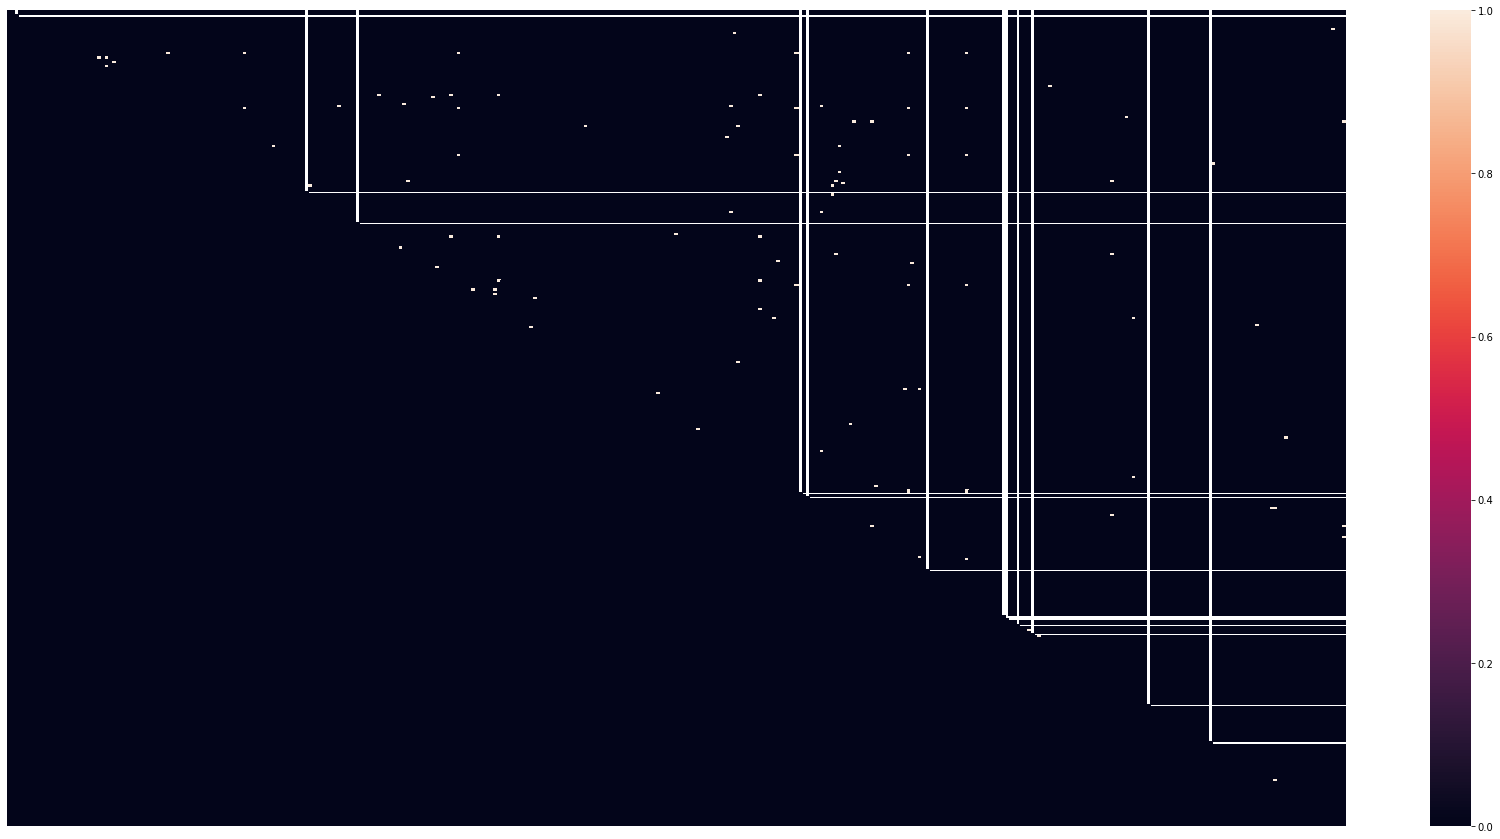

In [10]:
plot_identical_features(df_train)

In [11]:
# количество дубликатов

encoder = OneHotEncoder()
df_duplicated = encoder.fit_transform(df_train, cols=df_train.select_dtypes(include='object').columns.values)
print(f"Коллицество дубликатов: {df_duplicated.drop(columns=['y']).duplicated(keep=False).sum()}")

Коллицество дубликатов: 515


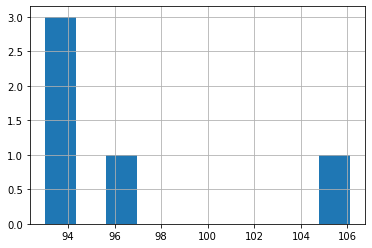

In [12]:
df_duplicated = df_duplicated[df_duplicated.drop(columns=['y']).duplicated(keep=False)]
similarity = cosine_similarity(df_duplicated.drop(columns=['y']))
# у одинаковых векторов разное значение целевой переменной
df_duplicated.iloc[np.where(similarity[0,:] > 0.99)[0]].y.hist();

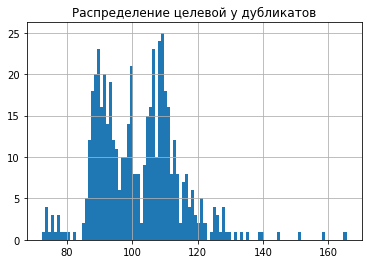

In [13]:
df_duplicated.y.hist(bins=100).set_title('Распределение целевой у дубликатов');

In [14]:
print(f"Количество статичных признаков: {(df_train.select_dtypes(include='int64').nunique() < 2).sum()}")

Количество статичных признаков: 12


# Пред обработка данных

## Чистка признаков

In [15]:
# отбросим статичные признаки
count_values = df_train.select_dtypes(include='int64').nunique()
static_features = count_values[count_values < 2].index.values
df_train.drop(columns=static_features, inplace=True)
df_val.drop(columns=static_features, inplace=True)

In [16]:
# найдем польностью скоррелированые бинарные признаки
identical_features = defaultdict(bool)

for _, features in get_identical_features(df_train.select_dtypes(include='int64').corr()).items():
  for feature in features:
    identical_features[feature] = True

identical_features = list(identical_features)

# отбросим польностью скоррелированые бинарные признаки
df_train.drop(columns=identical_features, inplace=True)
df_val.drop(columns=identical_features, inplace=True)

Идентичных бинарных признаков: 0


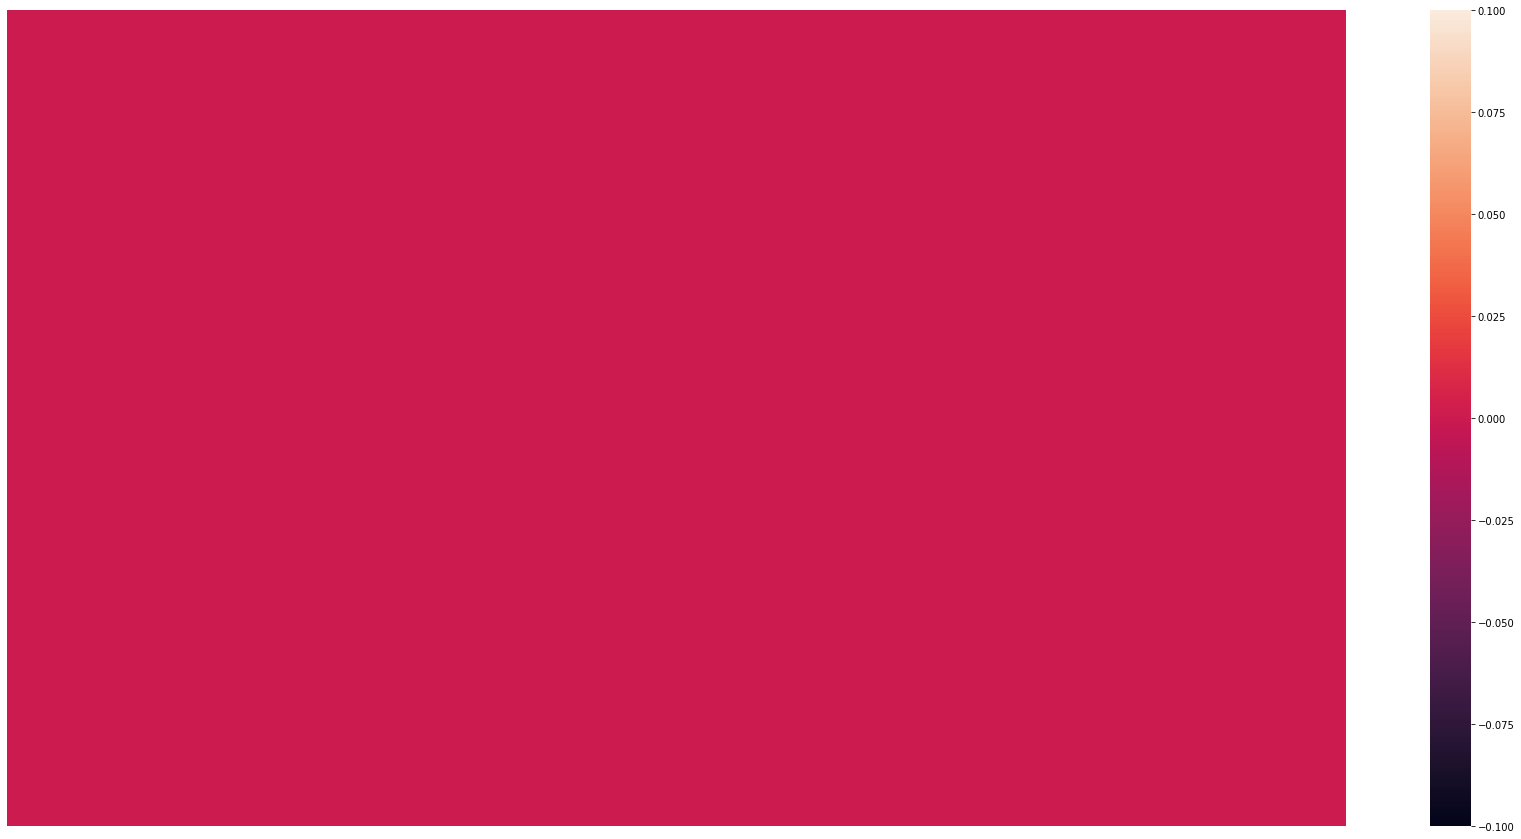

In [17]:
plot_identical_features(df_train)

## Чистка дубликатов

In [18]:
# найдем дубликаты
df = df_duplicated[['y']].copy()
df['cl'] = pd.Series(np.zeros(len(df), dtype=int))

for i in range(0, similarity.shape[0]):
  dup_index = np.where(similarity[i,:] > 0.99)[0]
  df.cl.iloc[dup_index] = i

# Найдем среднее значение целевой в каждой группе дубликатов
df = df.reset_index().set_index('cl')
df.update(df.groupby('cl').y.mean())
df = df.reset_index(drop=True).set_index('ID')

# обновим целевую для дубликатов средним значением для группы дубликатов
y_before = df_train.y
df_train.update(df)


# получим индексы для удаления дублей оставляя одно значение на группу
df_duplicated.update(df)
index_duplicate = df_duplicated[df_duplicated.duplicated()].index

# удалим дубликаты
df_train.drop(index_duplicate, inplace=True)
y_after = df_train.y


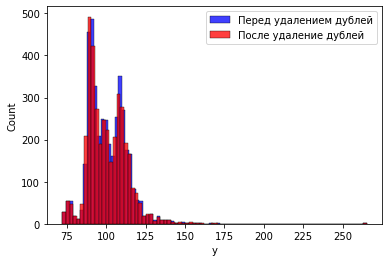

In [19]:
# посмотрим что стало с целевой после удаления дублей
sns.histplot(y_before, color='blue', label='Перед удалением дублей');
sns.histplot(y_after, color='red', label='После удаление дублей');
plt.legend();

## Поиск и удаление выбрасов

In [20]:
df_scale = df_train[['y']]
scaler = StandardScaler()
df_scale['y_scale'] = scaler.fit_transform(df_scale[['y']])

In [21]:
dbscan_model = DBSCAN(eps=0.005, min_samples=9)
dbscan_model.fit(df_scale[['y_scale']])
outlier = dbscan_model.labels_ == -1
print(f"Процент выбросов {round(outlier.sum()/outlier.shape[0]*100, 2)}")

Процент выбросов 14.17


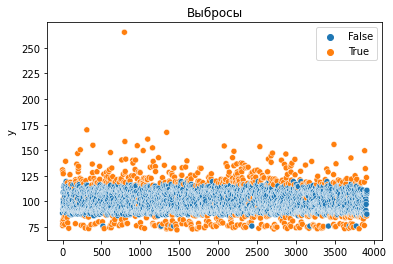

In [22]:
sns.scatterplot(data=df_scale, y='y', x=range(0, len(df_scale)), hue=outlier).set_title('Выбросы');

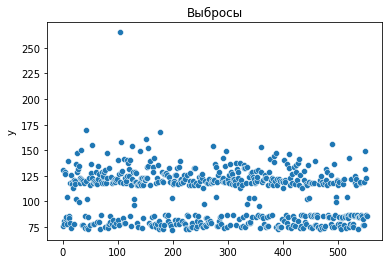

In [23]:
sns.scatterplot(data=df_scale[outlier], y='y', x=range(0, len(df_scale[outlier]))).set_title('Выбросы');

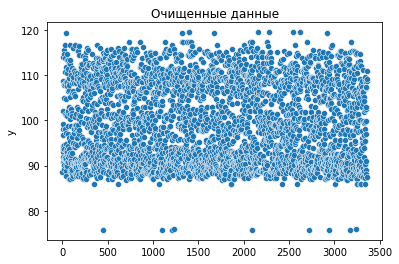

In [24]:
sns.scatterplot(data=df_scale[~outlier], y='y', x=range(0, len(df_scale[~outlier]))).set_title('Очищенные данные');

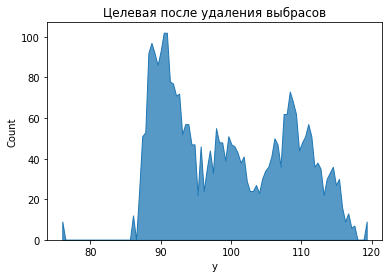

In [25]:
sns.histplot(data=df_train.drop(df_train[outlier].index), x='y', bins=100, element='poly').set_title("Целевая после удаления выбрасов");

In [26]:
# удалим выбросы
df_train.drop(df_train[outlier].index, inplace=True)

## Преоброзование категориальных признаков

In [27]:
def report(y_true, y_pred):
  print(f"R2: {r2_score(y_true, y_pred)}")
  print(f"RMSE: {mean_squared_error(y_true, y_pred)}")
  print(f"MAE: {mean_absolute_error(y_true, y_pred)}")

In [28]:
x_train, x_test, y_train, y_test = train_test_split(
    df_train.drop(columns=['y']),
    df_train.y,
    test_size=0.2,
    random_state=32
    )

In [29]:
category_features = list(df_train.select_dtypes(include='object').columns)
encoder = CatBoostEncoder(cols=category_features)
x_train = encoder.fit_transform(x_train, y=y_train)
x_test = encoder.transform(x_test)

In [30]:
scaler = StandardScaler()
x_train.update(pd.DataFrame(
    scaler.fit_transform(x_train[category_features]),
    columns=category_features,
    index=x_train.index
  ))
x_test.update(pd.DataFrame(
    scaler.fit_transform(x_test[category_features]),
    columns=category_features,
    index=x_test.index
  ))

In [31]:
# преобразуем валидационный набор который будет отправлятся на проверку
x_val = encoder.transform(df_val)
x_val.update(pd.DataFrame(
    scaler.fit_transform(x_val[category_features]),
    columns=category_features,
    index=x_val.index
  ))

In [32]:
x_val.head(10)

,X0,X1,X2,X3,X4,X5,X6,X8,X10,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X36,X38,X40,X41,X42,X43,X44,X45,X46,...,X337,X338,X339,X340,X341,X342,X343,X344,X345,X346,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X361,X362,X363,X366,X367,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X383,X384
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,-1.868736,0.974580,-0.710563,-1.408383,-0.015874,-0.037451,-2.245700,-1.177645,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,-0.907510,-0.865856,-1.431123,0.521903,-0.015874,-0.037451,-0.517885,-0.149839,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,-1.868736,0.974580,0.608397,-1.408383,-0.015874,-0.037451,0.505595,0.055822,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,-1.868736,-0.001134,-0.710563,-1.408383,-0.015874,-0.037451,-1.297710,0.711682,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,1.254365,0.787309,0.608397,0.326335,-0.015874,-0.037451,0.165392,-0.045153,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
8,-0.884773,-0.475778,-1.431123,-0.454007,-0.015874,-0.037451,-0.517885,-0.516378,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
10,1.205390,-0.865856,-0.856440,2.458660,-0.015874,-0.037451,1.006426,-0.149839,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
11,-0.762929,0.787309,-0.856440,0.326335,-0.015874,-0.037451,1.006426,-0.703082,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
12,1.619583,-0.001134,2.799753,0.326335,-0.015874,-0.037451,0.505595,0.711682,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


# Обучение моделей

In [33]:
df_score = pd.DataFrame(columns=['score', 'feature', 'model'])

# для поиска оптимальных гипер параметров

def search_optimal_params(model, params, data, target, metric):
  x_train, x_test, y_train, y_test = train_test_split(
        data,
        target,
        random_state=32,
        test_size=0.3
    )
  
  def search(params=params):
    model.set_params(**params)
    model.fit(x_train, y_train)
    return metric(y_test, model.predict(x_test))
  
  return fmin(fn=search, space=params, algo=tpe.suggest, max_evals=100)

In [34]:
# сохранение ответов для отправки
def save_submission(data, name='submission'):
    data.to_csv(f"{name}.csv")

In [35]:
# для отображения топ важности признаков по абсолютному значения
def plot_feature_importance(features_name, coef, top=10):
    feature_importance = pd.DataFrame({
        'feature': features_name,
        'importance': coef
    })
    feature_importance['abs'] = feature_importance.importance.abs()
    feature_importance.sort_values(['abs'], ascending=False, inplace=True)
    feature_importance.set_index('feature', inplace=True)
    feature_importance = feature_importance.iloc[:top, :].sort_values(['importance'], ascending=False)
    feature_importance.importance.plot(kind='bar')

## Линейная модель




In [36]:
params = {
    'alpha': hp.uniform('alpha', 0., 2.),
    'l1_ratio':  hp.uniform('l1_ratio', 0., 2.)
}

liner_best_params = search_optimal_params(ElasticNet(),params, x_train, y_train, mean_absolute_error)
print(f"Лучшие гипер параметры: {liner_best_params}")

100%|██████████| 100/100 [00:12<00:00,  7.94it/s, best loss: 3.849489661039768]
Лучшие гипер параметры: {'alpha': 0.04964706306184981, 'l1_ratio': 0.9408303748296681}


In [37]:
liner_model = ElasticNet(**liner_best_params)
liner_model.fit(x_train, y_train)

ElasticNet(alpha=0.04964706306184981, copy_X=True, fit_intercept=True,
           l1_ratio=0.9408303748296681, max_iter=1000, normalize=False,
           positive=False, precompute=False, random_state=None,
           selection='cyclic', tol=0.0001, warm_start=False)

In [38]:
report(y_train, liner_model.predict(x_train))

R2: 0.6714231366789437
RMSE: 25.954380282657723
MAE: 3.745894856337998


In [39]:
report(y_test, liner_model.predict(x_test))

R2: 0.7016399041070573
RMSE: 23.156503704156172
MAE: 3.623540032454125


In [40]:
df_score = df_score.append(
    {
      'score': mean_absolute_error(y_test, liner_model.predict(x_test)),
      'feature': 'all',
      'model': 'liner' 
    }, ignore_index=True
)

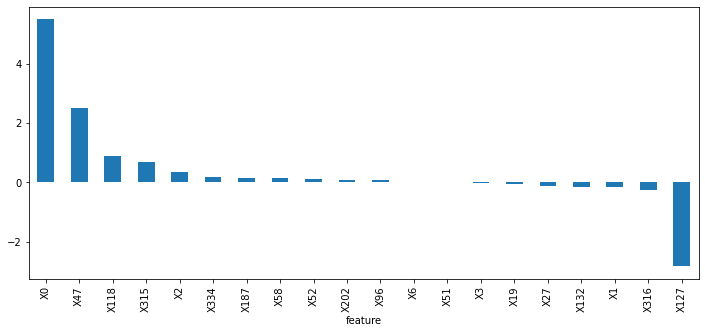

In [41]:
# посмотрим самые важные признаки
plt.figure(figsize=(12,5))
plot_feature_importance(x_train.columns.values, liner_model.coef_, top=20)

In [42]:
# для отправки результата
df_submit = pd.DataFrame({'ID': x_val.index, 'y': liner_model.predict(x_val)}).set_index('ID')
save_submission(df_submit, 'new_liner_2020_02_07')

## LGBM

In [43]:
# подбор параметров
params = {
    'max_depth': hp.choice('max_depth', range(1, 3)),
    'n_estimators': hp.choice('n_estimators', range(1, 300)),
    'reg_alpha': hp.uniform('reg_alpha', 0., 1),
    'reg_lambda': hp.uniform('reg_lambda', 0., 1),
    'num_leaves': hp.choice('num_leaves', range(2, 100)),
    'min_child_samples': hp.choice('min_child_samples', range(1, 100))
}
lgbm_best_params = search_optimal_params(LGBMRegressor(), params, x_train, y_train, mean_absolute_error)
print(f"Лучшие гипер параметры: {lgbm_best_params}")

100%|██████████| 100/100 [00:20<00:00,  4.85it/s, best loss: 3.744225442209737]
Лучшие гипер параметры: {'max_depth': 1, 'min_child_samples': 5, 'n_estimators': 102, 'num_leaves': 27, 'reg_alpha': 0.9997086755498834, 'reg_lambda': 0.0024466181719958596}


In [44]:
lgbm_model = LGBMRegressor(**lgbm_best_params)
lgbm_model.fit(x_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=1,
              min_child_samples=5, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=102, n_jobs=-1, num_leaves=27, objective=None,
              random_state=None, reg_alpha=0.9997086755498834,
              reg_lambda=0.0024466181719958596, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [45]:
report(y_train, lgbm_model.predict(x_train))

R2: 0.6854129794950212
RMSE: 24.849318602802626
MAE: 3.6862285881323262


In [46]:
report(y_test, lgbm_model.predict(x_test))

R2: 0.7057025306151166
RMSE: 22.84119268543257
MAE: 3.5716816314425266


In [47]:
df_score = df_score.append(
    {
      'score': mean_absolute_error(y_test, lgbm_model.predict(x_test)),
      'feature': 'all',
      'model': 'lgbm' 
    }, ignore_index=True
)

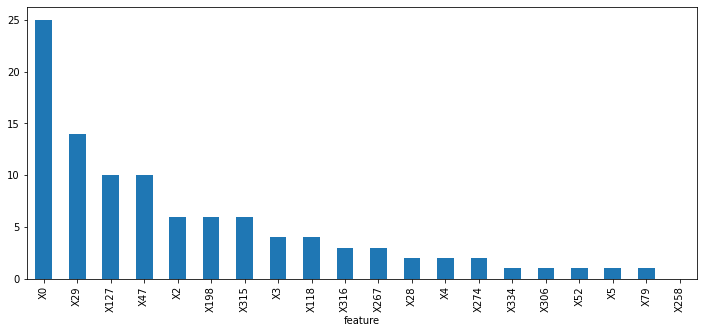

In [48]:
# посмотрим самые важные признаки
plt.figure(figsize=(12,5))
plot_feature_importance(x_train.columns.values, lgbm_model.feature_importances_, top=20)


# Финальная модель на отобранных признаках

In [49]:
def get_feature_importances(features, importances, top=20):
  index_features = np.argsort(importances)[-top:]
  return features[index_features]

In [50]:
# отберем пересечение самых важных признаков по версии линейной и деревянной модели
all_feature = x_train.columns.values
top_features = set(get_feature_importances(all_feature, lgbm_model.feature_importances_))
top_features = list(top_features.intersection(get_feature_importances(all_feature, liner_model.coef_)))

In [51]:
params = {
    'n_alphas': hp.choice('n_alphas', range(50, 200)),
    'l1_ratio':  hp.uniform('l1_ratio', 0., 2.),
    'eps': hp.uniform('eps', 0.001, 0.1)
}

best_of_the_best_params = search_optimal_params(ElasticNetCV(cv=6), params, x_train[top_features], y_train, mean_absolute_error)
print(f"Лучшие гипер параметры: {best_of_the_best_params}")

100%|██████████| 100/100 [00:23<00:00,  4.21it/s, best loss: 3.860955721738932]
Лучшие гипер параметры: {'eps': 0.0049936387262182, 'l1_ratio': 1.070384850369932, 'n_alphas': 11}


In [52]:
best_of_the_best = ElasticNetCV(cv=6, **best_of_the_best_params)
best_of_the_best.fit(x_train[top_features], y_train)

ElasticNetCV(alphas=None, copy_X=True, cv=6, eps=0.0049936387262182,
             fit_intercept=True, l1_ratio=1.070384850369932, max_iter=1000,
             n_alphas=11, n_jobs=None, normalize=False, positive=False,
             precompute='auto', random_state=None, selection='cyclic',
             tol=0.0001, verbose=0)

In [54]:
report(y_train, best_of_the_best.predict(x_train[top_features]))

R2: 0.6663235347083543
RMSE: 26.35719929887537
MAE: 3.7743434459810534


In [55]:
report(y_test, best_of_the_best.predict(x_test[top_features]))

R2: 0.7008781226564733
RMSE: 23.21562754553118
MAE: 3.619355033016901


In [56]:
df_score = df_score.append(
    {
      'score': mean_absolute_error(y_test, best_of_the_best.predict(x_test[top_features])),
      'feature': f'top {len(top_features)} features',
      'model': 'linerCV' 
    }, ignore_index=True
)

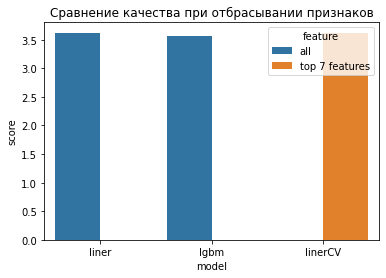

In [57]:
sns.barplot(data=df_score, x='model', y='score', hue='feature').set_title('Сравнение качества при отбрасывании признаков');

Можно оставить всего 7 признаков из порядка 300 без сильной патери качества

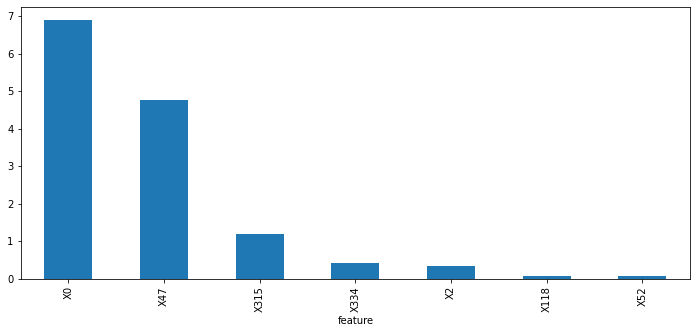

In [58]:
# посмотрим самые важные признаки
plt.figure(figsize=(12,5))
plot_feature_importance(top_features, best_of_the_best.coef_, top=20)